## Loading the environments

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

# Importing packages

In [3]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

from langgraph.graph import StateGraph , START , END , MessageGraph 
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from typing import TypedDict


In [4]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [ ]:
# from langchain_google_genai import ChatGoogleGenerativeAI
# model = ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0)

In [5]:
model.invoke("Hello, how are you?")

AIMessage(content="Hello! I'm doing well, thank you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 13, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BzoV3MUduJiiAMocD95tcusyZOsoT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a8c8a51e-e408-4989-b679-34d5d20c93e1-0', usage_metadata={'input_tokens': 13, 'output_tokens': 16, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Some utility functions

In [6]:

# to display the graph
def display_graph(app):
    # this function will display the graph of the app
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        # This requires some extra dependencies and is optional
        print(e)



# To stream the output of the app
def stream_output(app, input):
    for output in app.stream(input):
        for key,value in output.items():
            print(f"here is output from {key}")
            print("_______")
            print(value)
            print("\n")

In [7]:
# define the state
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list,add_messages]

## Level 0 : Start with simple worflow

In [11]:
def greet_user(state:State):
    """
    This function will greet the user with a message
    """
    user_message = state["messages"][0].content
    return {"messages" : [f"Hello {user_message}!"]}



In [12]:
#define the graph
graph = StateGraph(State)
graph.add_node("User_greetings" , greet_user)

graph.add_edge(START , "User_greetings")
graph.add_edge("User_greetings" , END)
app = graph.compile()

In [13]:
app.invoke({"messages":"Suman"})

{'messages': [HumanMessage(content='Suman', additional_kwargs={}, response_metadata={}, id='17ef4e4c-6ee5-48cf-af29-4f55a32b352e'),
  HumanMessage(content='Hello Suman!', additional_kwargs={}, response_metadata={}, id='94d5f99d-c41c-4611-9d65-7b5500d23db3')]}

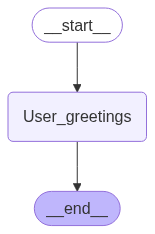

In [14]:
display_graph(app)

In [21]:
stream_output(app,{"messages": "Suman"})

here is output from User_greetings
_______
{'messages': ['Hello Suman!']}


here is output from Uppercase_converter
_______
{'messages': ['HELLO SUMAN!']}




## Level 1:    2 Workflows in a graph

In [22]:
def greet_user(state: State):
    """
    This function will greet the user with a message
    """
    user_message = state["messages"][0].content
    
    return {"messages": [f"Hello {user_message}!"]}

def convert_to_uppercase(state: State):
    """
    This function will convert the input word to uppercase
    """
    last_message = state["messages"][-1].content
    return {"messages": [last_message.upper()]}


In [23]:
#define the workflow

workflow = StateGraph(State)
workflow.add_node("User_greetings" , greet_user)
workflow.add_node("Uppercase_converter" , convert_to_uppercase)

workflow.add_edge(START , "User_greetings")
workflow.add_edge("User_greetings" , "Uppercase_converter")
workflow.add_edge("Uppercase_converter" , END)
app = workflow.compile()


In [24]:
app.invoke({"messages": "Suman"})

{'messages': [HumanMessage(content='Suman', additional_kwargs={}, response_metadata={}, id='58e2b776-486e-4f3f-9b5d-8bdc3db1b593'),
  HumanMessage(content='Hello Suman!', additional_kwargs={}, response_metadata={}, id='5debee5d-cf0a-4f49-91c7-1d3b1918cc07'),
  HumanMessage(content='HELLO SUMAN!', additional_kwargs={}, response_metadata={}, id='d0d22875-95a4-4e8f-8bd0-e65319be972a')]}

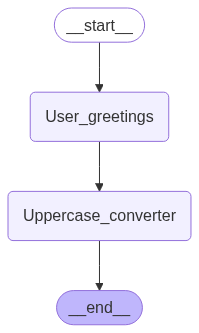

In [25]:
display_graph(app)

In [26]:
stream_output(app, {"messages": "Suman"})

here is output from User_greetings
_______
{'messages': ['Hello Suman!']}


here is output from Uppercase_converter
_______
{'messages': ['HELLO SUMAN!']}




## Level 2 : Using an LLM and a function

In [28]:
def get_response_from_llm(state: State):
    """
    This function will get the response from the LLM
    """
    user_input = state["messages"][0].content
    response = model.invoke(user_input)
    return {"messages": [response]}


def convert_to_uppercase(state:State):
    """
    This function will convert the message to uppercase
    """
    response_from_llm = state["messages"][-1].content
    uppercase_output = response_from_llm.upper()
    
    return {"messages": [uppercase_output]}



In [ ]:
# define the workflow

workflow = StateGraph(State)
workflow.add_node("LLM_response" , get_response_from_llm)
workflow.add_node("Uppercase_converter" , convert_to_uppercase)

workflow.add_edge(START , "LLM_response")
workflow.add_edge("LLM_response" , "Uppercase_converter")
workflow.add_edge("Uppercase_converter" , END)
app = workflow.compile()


In [30]:
app.invoke({"messages": "Hello, how are you?"})

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='1bc4e8dd-1718-4a44-917d-13a5d448466d'),
  AIMessage(content="Hello! I'm doing well, thank you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 13, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_658b958c37', 'id': 'chatcmpl-BzodcQw2Jk9WgwKebDb1MXpXzqprK', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8eb51ff9-b29e-44e4-992d-8cce2aaaddf6-0', usage_metadata={'input_tokens': 13, 'output_tokens': 16, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoni

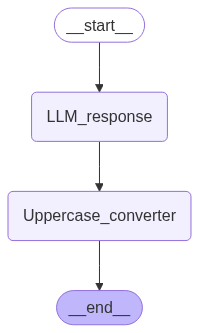

In [31]:
display_graph(app)

In [32]:
stream_output(app, {"messages": "Hello, how are you?"})

here is output from LLM_response
_______
{'messages': [AIMessage(content="Hello! I'm doing well, thank you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 13, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-Bzodt9oXhitJ3I2v0RNqDtmGx11CJ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--4c62684c-fdb8-4c0b-81b3-f115751015b5-0', usage_metadata={'input_tokens': 13, 'output_tokens': 16, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


here is output from Uppercase_converter
_______
{'messages': ["HELLO! I'M DOING

## Level 3: real world use case

In [36]:
def classify_sentiment(state:State):
    """
    This function will classify the sentiment of the message
    """
    user_input = state["messages"][0].content
    prompt = f"You are a sentiment classifier. You will be given a message and you will need to classify the sentiment of the message. The sentiment can be positive, negative or neutral. Return the sentiment as a string."
    final_message = user_input + prompt
    response = model.invoke(final_message).content
    return {"messages": [response]}


def get_total_word_count(state):
    """
    This function will get the total word count of the message
    """
    user_input = state["messages"][0].content
    word_count = len(user_input.split())
    return {"messages": [f"Total word count: {word_count}"]}


In [37]:
workflow = StateGraph(State)
workflow.add_node("Sentiment_classifier" , classify_sentiment)
workflow.add_node("Total_word_counter" , get_total_word_count)
workflow.add_edge(START , "Sentiment_classifier")
workflow.add_edge("Sentiment_classifier" , "Total_word_counter")
workflow.add_edge("Total_word_counter" , END)
app = workflow.compile()

In [38]:
app.invoke({"messages": "I am happy with the quality of the product and the service"})

{'messages': [HumanMessage(content='I am happy with the quality of the product and the service', additional_kwargs={}, response_metadata={}, id='0dcf9a2f-7963-4156-8f52-64558a5ad000'),
  HumanMessage(content='positive', additional_kwargs={}, response_metadata={}, id='0928e3df-21c5-4744-b10a-49edf63dfb46'),
  HumanMessage(content='Total word count: 12', additional_kwargs={}, response_metadata={}, id='9a1a2ee6-c65a-434f-b1c3-2b62e88fb33a')]}

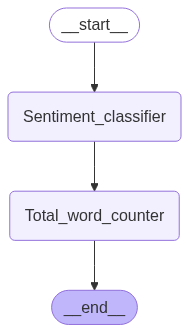

In [39]:
display_graph(app)

In [40]:
stream_output(app, {"messages": "I am happy with the product"})

here is output from Sentiment_classifier
_______
{'messages': ['positive']}


here is output from Total_word_counter
_______
{'messages': ['Total word count: 6']}




## Primer : Prompt Templates

### 1. Basic message templates - for static messages

In [ ]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()

model = ChatOpenAI(model='gpt-4.1-mini', temperature=0)

result = model.invoke("Write a 5 line poem on cricket")

print(result.content)

## 2. PromptTemplate - for dynamic messages

In [ ]:
from langchain_core.prompts import PromptTemplate

# using prompt Template
template = PromptTemplate(
    template='Write a short story about a person named {name} who discovers a hidden talent.',
    input_variables=['name']
)

# fill the values of the placeholders
prompt = template.invoke({'name':'Suman'})

result = model.invoke(prompt)

print(result.content)


## 2.1 PromptTemplate - for dynamic messages having multiple input variables

In [ ]:
from langchain_core.prompts import PromptTemplate

# Prompt template
template = PromptTemplate(
    template="""

    Please summarize the research paper titled "{paper_input}" with the following specifications:
    Explanation Style: {style_input}  
    Explanation Length: {length_input}  
    1. Mathematical Details:  
    - Include relevant mathematical equations if present in the paper.  
    - Explain the mathematical concepts using simple, intuitive code snippets where applicable.  
    2. Analogies:  
    - Use relatable analogies to simplify complex ideas.  
    If certain information is not available in the paper, respond with: "Insufficient information available" instead of guessing.  
    Ensure the summary is clear, accurate, and aligned with the provided style and length.
    """,
    input_variables=['paper_input', 'style_input','length_input'],
    validate_template=True
)

# template_structure  = template.invoke({'paper_input': 'The paper is about the theory of relativity', 
#                                        'style_input': 'Simple and intuitive', 
#                                        'length_input': '500 words'})

# print(str(template_structure))

chain = template | model


result = chain.invoke({
    'paper_input':'Attention is all you need',
    'style_input':'Simple and intuitive',
    'length_input':'200 words'
})

print(result.content)



## 3. How does a Langchain/Langgraph under the hood works

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()

model = ChatOpenAI(model='gpt-4.1-mini', temperature=0)

messages=[
    SystemMessage(content='You are a helpful assistant'),
    HumanMessage(content='Tell me about TajMahal')
]

result = model.invoke(messages)

messages.append(AIMessage(content=result.content))

print(messages)

## 3.1 when multiple message happen - ChatPromptTemplate

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

chat_template = ChatPromptTemplate([
    ('system', 'You are a helpful {domain} expert'),
    ('human', 'Explain in simple terms, what is {topic}')
])

prompt = chat_template.invoke({'domain':'cricket','topic':'Dusra'})

model.invoke(prompt)

## 3.2 when chathistory is required to understand the context

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from dotenv import load_dotenv

load_dotenv()

model = ChatOpenAI(model='gpt-4.1-mini', temperature=0)

chat_history = [
    SystemMessage(content='You are a helpful AI assistant')
]

while True:
    user_input = input('You: ')
    chat_history.append(HumanMessage(content=user_input))
    if user_input == 'exit':
        break
    result = model.invoke(chat_history)
    chat_history.append(AIMessage(content=result.content))
    print("AI: ",result.content)

print(chat_history)

In [ ]:
[SystemMessage(content='You are a helpful AI assistant', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}), HumanMessage(content='can you tell me about tajmahal', additional_kwargs={}, response_metadata={}), AIMessage(content='Certainly! The Taj Mahal is a famous monument located in Agra, India. It is widely regarded as one of the most beautiful buildings in the world and is a UNESCO World Heritage Site.\n\nHere are some key details about the Taj Mahal:\n\n- **History:** The Taj Mahal was commissioned by the Mughal Emperor Shah Jahan in 1632 in memory of his beloved wife Mumtaz Mahal, who died during childbirth. It serves as her mausoleum.\n\n- **Architecture:** The Taj Mahal is an outstanding example of Mughal architecture, which combines elements from Islamic, Persian, Ottoman Turkish, and Indian architectural styles. It is made primarily of white marble and is renowned for its symmetrical design, intricate carvings, and beautiful inlay work with precious and semi-precious stones.\n\n- **Structure:** The complex includes a main gateway, a beautiful garden, a mosque, a guest house, and the main mausoleum with a large dome and four minarets at the corners.\n\n- **Significance:** The Taj Mahal symbolizes eternal love and is one of the most visited tourist attractions in India, drawing millions of visitors each year.\n\nIf you want, I can provide more detailed information about its history, architecture, or visiting tips!', additional_kwargs={}, response_metadata={}), HumanMessage(content='ok who built it', additional_kwargs={}, response_metadata={}), AIMessage(content='The Taj Mahal was built by the Mughal Emperor Shah Jahan. He commissioned its construction in 1632 as a mausoleum for his beloved wife, Mumtaz Mahal, who passed away during childbirth. The construction took about 22 years to complete, finishing around 1653. A large workforce of skilled artisans, craftsmen, and laborers from across India and other parts of Asia were involved in building this magnificent monument. The chief architect is believed to be Ustad Ahmad Lahori.', additional_kwargs={}, response_metadata={}), HumanMessage(content='exit', additional_kwargs={}, response_metadata={})]

## 3.3 When chathistory needs to be put in the system to continue the conversation

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

model = ChatOpenAI(model='gpt-4.1-mini', temperature=0)

#past chat history
chat_history = [
    HumanMessage(content="I want to request a refund for my order #12345."),
    AIMessage(content="Your refund request for order number 11564 has been initiated. It will be processed in 3-5 business days.")
    ]

# chat template
chat_template = ChatPromptTemplate([
    ('system','You are a helpful customer support agent'),
    MessagesPlaceholder(variable_name='chat_history'),
    ('human','{query}')
])

# create prompt
prompt = chat_template.invoke({'chat_history':chat_history, 'query':'Where is my refund'})

result = model.invoke(prompt)

In [ ]:
result.content

## lets take the real world use case

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage


def sentiment_classifier(state:State):
    """
    This function will classify the sentiment of the message
    """
    user_query = state["messages"][0].content

    sentiment_classifier_template = ChatPromptTemplate(
        [
        ('system','You are a sentiment classifier. You will be given a message and you will need to classify the sentiment of the message. The sentiment can be positive, negative or neutral. Return the sentiment as a string.'),
        ('human','{query}')
        ])

    sentiment_classifier_chain = sentiment_classifier_template | model

    result = sentiment_classifier_chain.invoke({'query':user_query})

    return {"messages": [result.content]}


def get_total_word_count(state):
    """
    This function will get the total word count of the message
    """
    # response_from_llm = state["messages"][-1].content
    user_query = state["messages"][0].content
    word_count = len(user_query.split())
    return {"messages": [f"Total word count: {word_count}"]}